In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

# Multiple Runs Interface Usage Wit DB Writer

In this example, we are going to audit 4 models for stability and fairness, visualize metrics, and create an analysis report. To get better analysis accuracy, we will use `compute_metrics_multiple_runs` interface that will make multiple runs per model. For that, we will need to do the next steps:

* Initialize input variables

* Compute subgroup metrics

* Make group metrics composition

* Create metrics visualizations and an analysis report

## Import dependencies

In [6]:
import os
import pandas as pd
from datetime import datetime, timezone

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from virny.user_interfaces.metrics_computation_interfaces import compute_metrics_multiple_runs_with_db_writer
from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.custom_classes.base_dataset import BaseDataset
from virny.configs.constants import ReportType

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* A **config yaml** that is a file with configuration parameters for different user interfaces for metrics computation.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits of multiple models for one or multiple runs and analyze different types of models.

### Create a Dataset class

Based on the BaseDataset class, your **dataset class** should include the following attributes:

* **Obligatory attributes**: dataset, target, features, numerical_columns, categorical_columns

* **Optional attributes**: X_data, y_data, columns_with_nulls

For more details, please refer to the library documentation.

In [7]:
class CompasWithoutSensitiveAttrsDataset(BaseDataset):
    """
    Dataset class for COMPAS dataset that does not contain sensitive attributes among feature columns
     to test blind classifiers

    Parameters
    ----------
    dataset_path
        Path to a dataset file

    """
    def __init__(self, dataset_path: str):
        # Read a dataset
        df = pd.read_csv(dataset_path)

        # Initial data types transformation
        int_columns = ['recidivism', 'age', 'age_cat_25 - 45', 'age_cat_Greater than 45',
                       'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M', 'sex']
        int_columns_dct = {col: "int" for col in int_columns}
        df = df.astype(int_columns_dct)

        # Define params
        target = 'recidivism'
        numerical_columns = ['juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count']
        categorical_columns = ['age_cat_25 - 45', 'age_cat_Greater than 45','age_cat_Less than 25',
                               'c_charge_degree_F', 'c_charge_degree_M']
        features = numerical_columns + categorical_columns

        super().__init__(
            pandas_df=df,
            features=features,
            target=target,
            numerical_columns=numerical_columns,
            categorical_columns=categorical_columns
        )

In [8]:
dataset = CompasWithoutSensitiveAttrsDataset(dataset_path=os.path.join('..', '..', 'data', 'COMPAS.csv'))
dataset.X_data[dataset.X_data.columns[:5]].head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat_25 - 45
0,0.0,-2.340451,1.0,-15.010999,1
1,0.0,0.000000,0.0,0.000000,1
2,0.0,0.000000,0.0,0.000000,0
3,0.0,0.000000,0.0,6.000000,1
4,0.0,0.000000,0.0,7.513697,1


### Create a config object

`compute_metrics_multiple_runs` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: a name of your dataset; it will be used to name files with metrics.

* **test_set_fraction**: the fraction from the whole dataset in the range [0.0 - 1.0] to create a test set.

* **bootstrap_fraction**: the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **n_estimators**: the number of estimators for bootstrap to compute subgroup variance metrics.

* **runs_seed_lst**: a list of seeds for each run; the number of runs is derived based on the length of this list. For example, if your runs_seed_lst is [100, 200], this means that for the first run, the interface will use 100 seed, and the code logic will increment this seed for each model (101 for the first model in models_config, 102 for the second model, etc.).

* **sensitive_attributes_dct**: a dictionary where keys are sensitive attribute names (including attribute intersections), and values are privileged values for these attributes. Currently, the library supports only intersections among two sensitive attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify privileged values for intersectional groups since they will be derived from privileged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.


In [9]:
ROOT_DIR = os.getcwd()
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_config.yaml')
config_yaml_content = \
"""dataset_name: COMPAS_Without_Sensitive_Attributes
test_set_fraction: 0.2
bootstrap_fraction: 0.8
n_estimators: 50  # Better to input the higher number of estimators than 100; this is only for this use case example
runs_seed_lst: [100, 200, 300, 400, 500]
sensitive_attributes_dct: {'sex': 0, 'race': 'Caucasian', 'sex&race': None}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [10]:
config = create_config_obj(config_yaml_path=config_yaml_path)

### Create a models config

**models_config** is a Python dictionary, where keys are model names and values are initialized models for analysis

In [11]:
models_config = {
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion='gini',
                                                     max_depth=20,
                                                     max_features=0.6,
                                                     min_samples_split=0.1),
    'LogisticRegression': LogisticRegression(C=1,
                                             max_iter=50,
                                             penalty='l2',
                                             solver='newton-cg'),
    'RandomForestClassifier': RandomForestClassifier(max_depth=4,
                                                     max_features=0.6,
                                                     min_samples_leaf=1,
                                                     n_estimators=50),
    'XGBClassifier': XGBClassifier(learning_rate=0.1,
                                   max_depth=5,
                                   n_estimators=20),
}

## Subgroup Metrics Computation

After the variables are input to a user interface, the interface creates a **generic pipeline** based on the input dataset class to hide preprocessing complexity and provide handy attributes and methods for different types of model analysis. Later this generic pipeline is used in subgroup analyzers that compute different sets of metrics. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Statistical Bias Analyzer**, but it is easily extensible to any other analyzers. When the variance and bias analyzers complete metrics computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [13]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient


load_dotenv('../secrets.env')  # Take environment variables from .env

# Provide the mongodb atlas url to connect python to mongodb using pymongo
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
# Create a connection using MongoClient. You can import MongoClient or use pymongo.MongoClient
client = MongoClient(CONNECTION_STRING)
collection = client[os.getenv("DB_NAME")]['preprocessing_results']


def db_writer_func(run_models_metrics_df, collection=collection):
    # Rename Pandas columns to lower case
    run_models_metrics_df.columns = run_models_metrics_df.columns.str.lower()
    collection.insert_many(run_models_metrics_df.to_dict('records'))

In [14]:
import uuid

custom_table_fields_dct = {
    'session_uuid': str(uuid.uuid4()),
    'preprocessing_techniques': 'get_dummies and scaler',
}
print('Current session uuid: ', custom_table_fields_dct['session_uuid'])

In [18]:
multiple_run_metrics_dct = compute_metrics_multiple_runs_with_db_writer(dataset, config, models_config, custom_table_fields_dct,
                                                                        db_writer_func, debug_mode=False)

Multiple runs progress:   0%|          | 0/1 [00:00<?, ?it/s]

Analyze models in one run:   0%|          | 0/1 [00:00<?, ?it/s]

##############################  [Model 1 / 1] Analyze DecisionTreeClassifier  ##############################
Model seed:  101
Baseline X_train shape:  (4222, 9)
Baseline X_test shape:  (1056, 9)




2023-03-15 19:09:13 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/10 [00:00<?, ?it/s]

2023-03-15 19:09:13 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-03-15 19:09:13 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics


Look at several columns in top rows of computed metrics

In [16]:
sample_model_metrics_df = multiple_run_metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:6]].head(20)

,Metric,overall,sex_priv,sex_dis,race_priv,race_dis
0,Mean,0.527257,0.564303,0.518654,0.589932,0.484709
1,Std,0.074216,0.079314,0.073032,0.072666,0.075268
2,IQR,0.098053,0.102713,0.096971,0.097556,0.098390
3,Entropy,0.000000,0.000000,0.000000,0.000000,0.239298
4,Jitter,0.140123,0.157945,0.135985,0.116693,0.156029
5,Per_Sample_Accuracy,0.656534,0.668844,0.653676,0.655316,0.657361
6,Label_Stability,0.810417,0.785528,0.816196,0.841967,0.788998
7,TPR,0.597536,0.528571,0.609113,0.440252,0.673780
8,TNR,0.731107,0.782946,0.715909,0.787313,0.681063
9,PPV,0.655405,0.569231,0.670185,0.551181,0.697161


## Group Metrics Composition

**Metrics Composer** is responsible for this second stage of the model audit. Currently, it computes our custom group statistical bias and variance metrics, but extending it for new group metrics is very simple. We noticed that more and more group metrics have appeared during the last decade, but most of them are based on the same subgroup metrics. Hence, such a separation of subgroup and group metrics computation allows one to experiment with different combinations of subgroup metrics and avoid subgroup metrics recomputation for a new set of grouped metrics.

In [17]:
def read_model_metric_dfs_from_db(collection, session_uuid):
    cursor = collection.find({'session_uuid': session_uuid})
    records = []
    for record in cursor:
        del record['_id']
        records.append(record)

    model_metric_dfs = pd.DataFrame(records)

    # Capitalize column names to be consistent across the whole library
    new_column_names = []
    for col in model_metric_dfs.columns:
        new_col_name = '_'.join([c.capitalize() for c in col.split('_')])
        new_column_names.append(new_col_name)

    model_metric_dfs.columns = new_column_names
    return model_metric_dfs


def get_models_metrics_dct(model_metric_dfs):
    # Create columns based on values in the Subgroup column
    pivoted_model_metric_dfs = model_metric_dfs.pivot(columns='Subgroup', values='Metric_Value',
                                                      index=[col for col in model_metric_dfs.columns
                                                             if col not in ('Subgroup', 'Metric_Value')]).reset_index()
    pivoted_model_metric_dfs = pivoted_model_metric_dfs.rename_axis(None, axis=1)

    # Create a dict of metrics for each model
    models_metrics_dct = dict()
    for model_name in pivoted_model_metric_dfs['Model_Name'].unique():
        models_metrics_dct[model_name] = pivoted_model_metric_dfs[pivoted_model_metric_dfs['Model_Name'] == model_name]

    return models_metrics_dct

In [18]:
model_metric_dfs = read_model_metric_dfs_from_db(collection, custom_table_fields_dct['session_uuid'])
models_metrics_dct = get_models_metrics_dct(model_metric_dfs)

In [19]:
models_metrics_dct[list(models_metrics_dct.keys())[0]].head(20)

,Metric,Model_Seed,Model_Name,Run_Number,Dataset_Name,Num_Estimators,Tag,Record_Create_Date_Time,Session_Uuid,Preprocessing_Techniques,overall,race_dis,race_priv,sex&race_dis,sex&race_priv,sex_dis,sex_priv
0,Accuracy,101,DecisionTreeClassifier,Run_1,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:05:30.263,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.669508,0.677266,0.658080,0.666023,0.647727,0.663944,0.693467
4,Accuracy,201,DecisionTreeClassifier,Run_2,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:05:51.038,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.671402,0.675425,0.665037,0.676030,0.701149,0.668224,0.685000
8,Accuracy,301,DecisionTreeClassifier,Run_3,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:10.868,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.663826,0.684867,0.631325,0.684310,0.578947,0.670200,0.637681
12,Accuracy,401,DecisionTreeClassifier,Run_4,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:30.646,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.677083,0.687888,0.660194,0.693032,0.660000,0.680902,0.661972
16,Accuracy,501,DecisionTreeClassifier,Run_5,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:50.542,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.689394,0.699523,0.674473,0.714286,0.766990,0.688297,0.694301
20,Entropy,101,DecisionTreeClassifier,Run_1,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:05:30.263,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.000000,0.239298,0.000000,0.232191,0.000000,0.000000,0.000000
24,Entropy,201,DecisionTreeClassifier,Run_2,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:05:51.038,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.000000,0.000000,0.000000,0.000000,0.210120,0.000000,0.210887
28,Entropy,301,DecisionTreeClassifier,Run_3,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:10.868,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.173745,0.178353,0.166628,0.175775,0.000000,0.170206,0.188262
32,Entropy,401,DecisionTreeClassifier,Run_4,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:30.646,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.162800,0.000000,0.166147,0.000000,0.213982,0.154787,0.194514
36,Entropy,501,DecisionTreeClassifier,Run_5,COMPAS_Without_Sensitive_Attributes,50,OK,2023-03-16 22:06:50.542,c3fa1cc5-3255-4e19-a580-2d55a72fa6c2,get_dummies and scaler,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [21]:
models_composed_metrics_df = metrics_composer.compose_metrics()

## Metrics Visualization and Reporting

**Metrics Visualizer** provides metrics visualization and reporting functionality. It unifies different preprocessing methods for result metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the Metrics Visualizer class and get custom plots for diverse metrics analysis. Additionally, these plots could be collected in an HTML report with comments for user convenience and future reference.

In [22]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

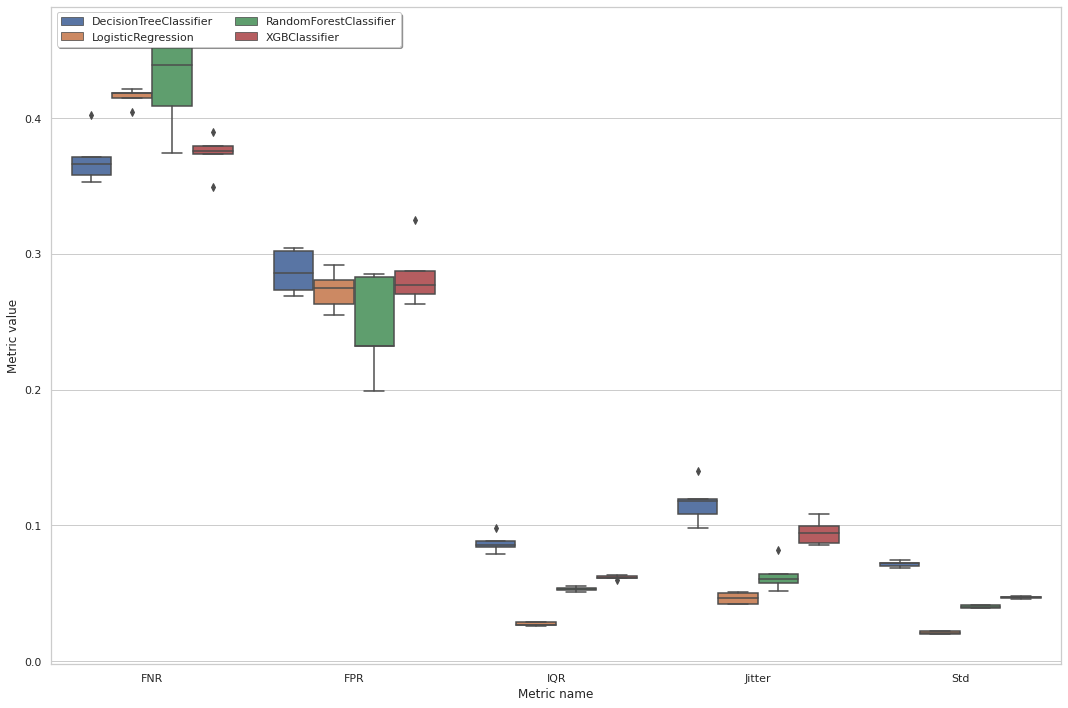

In [23]:
visualizer.create_boxes_and_whiskers_for_models_multiple_runs(metrics_lst=['Std', 'IQR', 'Jitter', 'FNR','FPR'])

In [24]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'],
    metrics_title="Bias Metrics"
)

alt.Chart(...)

In [25]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    metrics_title="Variance Metrics"
)

alt.Chart(...)

Below is an example of an interactive plot. It requires that you run the below cell in Jupyter in the browser or EDAs, which support JavaScript displaying.

You can use this plot to compare any pair of bias and variance metrics for all models.

In [26]:
visualizer.create_bias_variance_interactive_bar_chart()

alt.HConcatChart(...)

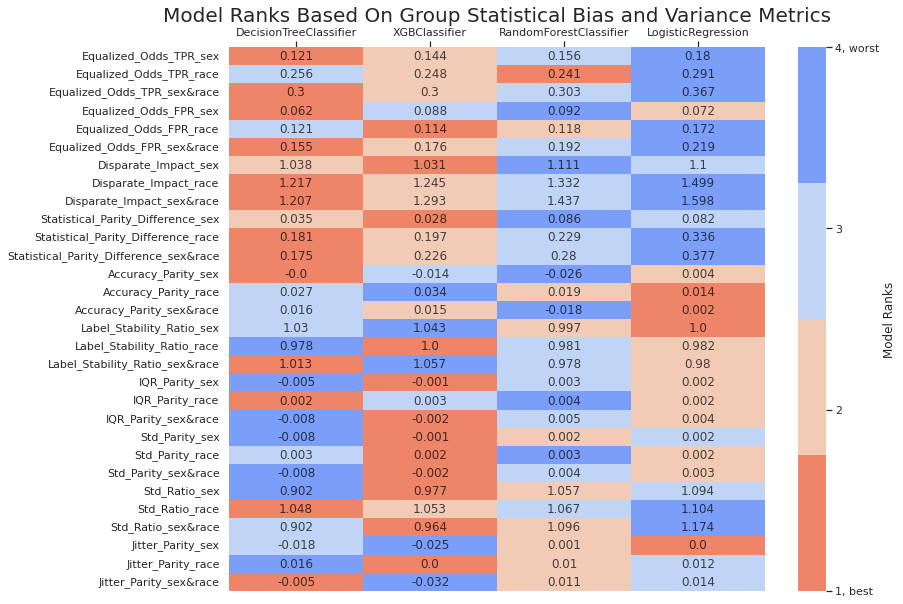

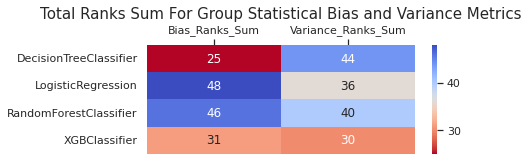

In [27]:
visualizer.create_model_rank_heatmaps(
    metrics_lst=[
        # Group statistical bias metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        'Statistical_Parity_Difference',
        'Accuracy_Parity',
        # Group variance metrics
        'Label_Stability_Ratio',
        'IQR_Parity',
        'Std_Parity',
        'Std_Ratio',
        'Jitter_Parity',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
)

Create an analysis report. It includes correspondent visualizations and details about your result metrics.

In [20]:
client.close()

In [28]:
visualizer.create_html_report(report_type=ReportType.MULTIPLE_RUNS_MULTIPLE_MODELS,
                              report_save_path=os.path.join("..", "..", "results", "reports"))

App saved to ./../../results/reports/COMPAS_Without_Sensitive_Attributes_Metrics_Report_20230316__221223.html